## Block Number Interpolation

(current using disambiguous v1)

1. Sequence Restriction

This notebook interpolates block numbers by filling in if unknown dwellings are in between known dwellings of the same
    1. block number
    2. block number and distance sequence
    3. block number, distance sequence, and enum_dist
    4. block number, distance sequence, enum_dist, and other sequence

2. Max Distance Restriction
3. In between number of dwellings



1. disambiguous and resolve conflicts [see Disambiguous_Analysis_ notebook for more detail]
2. Set the max number of dwellings between two known dwellings for sequence interpolation

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import disambiguation_analysis as da

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate sequences

* Start with ward 10

In [22]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                 fixed = True, distance = True)

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1


# 1. Sequence Restriction

## Process and interpolate

In [95]:
census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
dwellings_sequence = census_all_dwellings.dropna(subset=[block_col])

## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
## dwellings_sequence => known dwellings
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)

"""
2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
`num_between_real` are included in df of all known dwellings.
"""
dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                        block_col+'_next', 
                                                                                      'num_between_real',
                                                                                      'header']], 
                                                             on=[ward_col, dwelling_col], how='left')

In [135]:
all_dwellings_1 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_2 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id'], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_3 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id', 'enum_dist_id'], ward_col = ward_col, dwelling_col = dwelling_col)

all_dwellings_4 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = block_col,
                                                       check_column = [block_col, 'sequence_id', 
                                                                       'enum_dist_id', 'fixed_seq',
                                                                      'dwelling_seq_id'], ward_col = ward_col, dwelling_col = dwelling_col)

## Result

In [152]:
total_num_dwellings = census_all_dwellings.groupby([ward_col, dwelling_col]).ngroups
known_num_dwellings = census_all_dwellings.loc[~census_all_dwellings[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups

all_dwelling_list = [all_dwellings_1,all_dwellings_2, all_dwellings_3, all_dwellings_4]
in_between_num = 15
num_assigned_dwelling = []

print('Ward 10. Total number of Dwellings: ',total_num_dwellings)
for all_dwelling_x in all_dwelling_list:
    ##interpolated portion
    total_assigned_dwellings = all_dwelling_x.loc[~all_dwelling_x[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups
#     total_assigned_dwellings = with_block_num_dwellings.shape[0]
    num_assigned_dwelling.append(round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5))
    
    print("Maximum of {} dwellings between".format(str(in_between_num)))
    print("Number of dwellings that would be assigned a block:", total_assigned_dwellings - known_num_dwellings)
    print("Proportion increase dwellings assigned a block:", round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5), "\n")


Ward 10. Total number of Dwellings:  1973
Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a block: 0.09731 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a block: 0.09731 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 172
Proportion increase dwellings assigned a block: 0.08718 

Maximum of 15 dwellings between
Number of dwellings that would be assigned a block: 158
Proportion increase dwellings assigned a block: 0.08008 



Text(0.5, 1.0, 'Increase Proportion of Dwellings assigned a block')

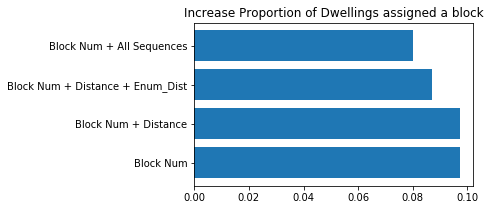

In [159]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.barh(['Block Num', 'Block Num + Distance', 'Block Num + Distance + Enum_Dist', 'Block Num + All Sequences'], num_assigned_dwelling)
# ax.scatter(num_between, num_assigned_dwelling)
ax.set_title("Increase Proportion of Dwellings assigned a block")

## Take a look at where they differ

* approach 1 (only looking at block num) and 2 (looking at block num + distance seqeunce) produce exact same output
* When approach 2 and 3 (~2 + enum_distance sequence) do not agree, approach is more reliable. Next known dwellings are still in the same block number. Enumerators start off their new days from where they left off the day before. 
* **Data in ward 10 supports the use of only distance sequence and block num to fill in missing block nums**

In [133]:
## both produce the same block number interpolation
(all_dwellings_1[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1)).sum()

0

In [139]:
## both produce the same block number interpolation
np.where(all_dwellings_3[block_col].replace(np.nan, -1) != all_dwellings_2[block_col].replace(np.nan, -1))

(array([ 110,  111,  215,  216,  217,  218,  265,  266,  267,  268,  269,
         270,  271,  309,  310,  311, 1144, 1145, 1146, 1147]),)

In [166]:
all_dwellings_2.merge(all_dwellings_3, on=[dwelling_col, 'sequence_id', 'enum_dist_id'],
                     how='left').iloc[105:130][['dwelling_id', 'block_num_x', 'block_num_y', 'sequence_id', 'enum_dist_id']]

,dwelling_id,block_num_x,block_num_y,sequence_id,enum_dist_id
105,106,1260.0,1260.0,105.0,105.0
106,107,NaN,NaN,NaN,NaN
107,108,NaN,NaN,NaN,NaN
108,109,195.0,195.0,127.0,109.0
109,110,195.0,195.0,127.0,109.0
110,111,195.0,NaN,NaN,NaN
111,112,195.0,NaN,NaN,NaN
112,113,195.0,195.0,127.0,127.0
113,114,195.0,195.0,127.0,127.0
114,115,NaN,NaN,NaN,NaN


In [167]:
all_dwellings_2.merge(all_dwellings_3, on=[dwelling_col, 'sequence_id', 'enum_dist_id'],
                     how='left').iloc[300:320][['dwelling_id', 'block_num_x', 'block_num_y', 'sequence_id', 'enum_dist_id']]

,dwelling_id,block_num_x,block_num_y,sequence_id,enum_dist_id
300,301,NaN,NaN,NaN,NaN
301,302,NaN,NaN,NaN,NaN
302,303,NaN,NaN,NaN,NaN
303,304,NaN,NaN,NaN,NaN
304,305,191.0,191.0,323.0,308.0
305,306,191.0,191.0,323.0,308.0
306,307,191.0,191.0,323.0,308.0
307,308,191.0,191.0,NaN,NaN
308,309,191.0,191.0,323.0,308.0
309,310,191.0,NaN,NaN,NaN


In [169]:
all_dwellings_2.merge(all_dwellings_3, on=[dwelling_col, 'sequence_id', 'enum_dist_id'],
                     how='left').iloc[1135:1155][['dwelling_id', 'block_num_x', 'block_num_y', 'sequence_id', 'enum_dist_id']]

,dwelling_id,block_num_x,block_num_y,sequence_id,enum_dist_id
1135,1136,201.0,201.0,1135.0,1135.0
1136,1137,NaN,NaN,NaN,NaN
1137,1138,NaN,NaN,NaN,NaN
1138,1139,NaN,NaN,NaN,NaN
1139,1140,NaN,NaN,NaN,NaN
1140,1141,NaN,NaN,NaN,NaN
1141,1142,NaN,NaN,NaN,NaN
1142,1143,NaN,NaN,NaN,NaN
1143,1144,200.0,200.0,1171.0,1143.0
1144,1145,200.0,NaN,NaN,NaN


# 2. Distance Threshold for distance sequence
# 3. In Between Num dwelling

In [173]:
distance_threshold = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
in_between_num_list = num_between = [5,10,15, 20, 25,40, None]
result_inbetween_distthreshold = {}
for in_between_num in in_between_num_list:
    result_list = []
    for max_dist in distance_threshold:

        census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                         fixed = True, distance = True, d = max_dist)

        census_all_dwellings = census_enum_seq.df.groupby([ward_col, dwelling_col], as_index = False).first()
        dwellings_sequence = census_all_dwellings.dropna(subset=[block_col])

        ## 1. Get dwellings that are followed by unknown dwellings whose block num can be interpolated
        ## dwellings_sequence => known dwellings
        dwelling_sequence_sames = interpolation.same_next(dwellings_sequence, column = block_col)

        """
        2. Merge dwelling_sequence_sames back to all known dwelling df so that `BLOCK_NUM_next` and 
        `num_between_real` are included in df of all known dwellings.
        """
        dwellings_sequence_with_next_info = dwellings_sequence.merge(dwelling_sequence_sames[[ward_col, dwelling_col,
                                                                                block_col+'_next', 
                                                                                              'num_between_real',
                                                                                              'header']], 
                                                                     on=[ward_col, dwelling_col], how='left')

        all_dwellings = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                               block_col = block_col, fill_column = block_col,
                                                               check_column = [block_col, 'sequence_id'], ward_col = ward_col, 
                                                                 dwelling_col = dwelling_col, dwelling_max = in_between_num)

        ##interpolated portion
        total_assigned_dwellings = all_dwellings.loc[~all_dwellings[block_col].isnull()].groupby([ward_col, dwelling_col]).ngroups
        result_list.append(round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5))

        print("Maximum of {} miles between each dwelling in a sequence".format(str(max_dist)))
        print("Maximum of {} dwellings in between".format(str(in_between_num)))
        print("Number of dwellings that would be assigned a block:", total_assigned_dwellings - known_num_dwellings)
        print("Proportion increase dwellings assigned a block:", round((total_assigned_dwellings - known_num_dwellings)/total_num_dwellings, 5), "\n")

        result_inbetween_distthreshold[in_between_num] = result_list

d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
d:  0.05
Maximum of 0.05 miles between each dwelling in a sequence
Maximum of 5 dwellings in between
Number of dwellings that would be assigned a block: 155
Proportion increase dwellings assigned a block: 0.07856 

d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.

Maximum of 0.25 miles between each dwelling in a sequence
Maximum of 10 dwellings in between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a block: 0.09731 

d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
d:  0.3
Maximum of 0.3 miles between each dwelling in a sequence
Maximum of 10 dwellings in between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a block: 0.09731 

d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35


d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
d:  0.1
Maximum of 0.1 miles between each dwelling in a sequence
Maximum of 20 dwellings in between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a block: 0.09731 

d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
d:  0.15
Maximum of 0.15 miles between each dwelling in a sequence
Maximum of 20 dwellings in between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a 

d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
d:  0.35
Maximum of 0.35 miles between each dwelling in a sequence
Maximum of 25 dwellings in between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a block: 0.09731 

d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
d:  0.4
Maximum of 0.4 miles between each dwelling in a sequence
Maximum of 25 dwellings in between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a

d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
d:  0.2
Maximum of 0.2 miles between each dwelling in a sequence
Maximum of None dwellings in between
Number of dwellings that would be assigned a block: 192
Proportion increase dwellings assigned a block: 0.09731 

d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  0.25
d:  

In [175]:
pd.DataFrame(result_inbetween_distthreshold) ##row: distance threshold, col: in between num

,5,10,15,20,25,40,NaN
0,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731
1,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731
2,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731
3,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731
4,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731
5,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731
6,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731
7,0.07856,0.09731,0.09731,0.09731,0.09731,0.09731,0.09731


* **Distance Threshold does not impact the block number interpolation**. (Same values along a column)

In [177]:
# fig, ax = plt.subplots(1,1, figsize=(5,3))
# ax.plot(distance_threshold, result_list)
# ax.scatter(distance_threshold, result_list)
# ax.set_title("Increase Proportion of Dwellings assigned a block")
# ax.set_xlabel('Distance Threshold for Distance Sequence')